In [2]:
# importing python utility libraries
import os, sys, random, io, urllib, importlib
from datetime import datetime

from pathlib import Path
home = str(Path.home())

#### clone from github repo
user = "ivivan"
repo = "FraudTransformer"
src_dir = "src"

if os.path.isdir(repo):
    !rm -rf {repo}

!git clone https://github.com/{user}/{repo}.git

path = f"{repo}/{src_dir}"
if not path in sys.path:
    sys.path.insert(1, path)


Cloning into 'FraudTransformer'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 68 (delta 23), reused 57 (delta 14), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [6]:
from utils.data_config import input_config
from models.tab_transformer import TabTransformer
from utils.fraud_data import FraudData
from utils.model_training import train_tool, test_tool, predict_prob,predict_prob_noy
from utils.early_stopping import EarlyStopping


# importing pytorch libraries
import torch
print(torch.__version__)
from torch import nn
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# model interpretation
!pip install shap
import shap
shap.initjs()
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# importing python plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
from IPython.display import Image, display
%load_ext autoreload
%autoreload 2

1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install transformers
from transformers import MobileBertConfig
from transformers import MobileBertTokenizer
from transformers import MobileBertForMaskedLM
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 0.0 Support Func

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')  # don't have GPU
    return device

# convert a df to tensor to be used in pytorch
def numpy_to_tensor(ay, tp):
    device = get_device()
    return torch.from_numpy(ay).type(tp).to(device)

### 1.1 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:

In [ ]:
# print CUDNN backend version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.cudnn.version()))

[LOG 20220705-22:51:02] The CUDNN backend version: 8200


### 1.2 CPU/GPU Device

In [ ]:
torch.backends.cudnn.benchmark = True 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
torch.cuda.device_count()

1

### 1.3 Python and PyTorch Verification

In [ ]:
# print current Python version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20220705-02:44:41] The Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [ ]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20220705-02:44:42] The PyTorch version: 1.11.0+cu113


### 1.4 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [ ]:
# init deterministic seed
seed_value = 1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.cudnn.version() != None):
    torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

### 1.5 Set Paths

## 2. Fraud Data

Load feature data generated by Flagship model, Step 2

> borrow some codes from flagship model

### 2.1 Load the Parsed Data

Load train/val/test data

In [7]:
input_features_df = pd.read_csv('./data/train.csv',index_col=0)

In [9]:
input_features_df.fillna(0,inplace=True)

In [10]:
modified_rcs_arr = input_features_df.columns

In [11]:
new_cols_0 = modified_rcs_arr + '_0'

In [12]:
new_cols_1 = modified_rcs_arr + '_1'

In [13]:
for i in range(0,input_features_df.shape[1]):
    input_features_df.iloc[:,i] = input_features_df.iloc[:,i].apply(lambda x: f"{modified_rcs_arr[i]}_{x}")

In [15]:
vocab = new_cols_0.to_list() + new_cols_1.to_list() + ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]','[BOS]','[EOS]']

In [14]:
# instantiate tokenizer using custom vocabulary
vocab_file = "checkpoints/fraudvocab.txt"

In [17]:
with open(vocab_file, 'w') as vocab_fp:
  vocab_fp.write("\n".join(vocab))

In [20]:
lis = input_features_df.astype(str).values.tolist()

In [21]:
for i,j in enumerate(lis):
    lis[i] = ' '.join(j)

In [15]:
special_tokens_dict = {"unk_token": "[UNK]", 
                       "sep_token": "[SEP]", 
                       "pad_token": "[PAD]", 
                       "cls_token": "[CLS]", 
                       "mask_token": "[MASK]",
                       "eos_token": "[EOS]",
                       "bos_token": "[BOS]"}

In [16]:
config = MobileBertConfig(
    vocab_size=100,
    max_position_embeddings=512,
    num_attention_heads=4,
    num_hidden_layers=6,
    hidden_size = 128,
)

In [17]:
tokenizer_fraud = MobileBertTokenizer(vocab_file,do_basic_tokenize=False)

In [18]:
tokenizer_fraud.add_special_tokens(special_tokens_dict)

0

In [22]:
batch_tokenized = tokenizer_fraud(lis[0])

In [23]:
batch_tokenized

{'input_ids': [93, 0, 1, 2, 3, 90, 90, 90, 90, 5, 6, 7, 8, 9, 10, 11, 12, 13, 59, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 71, 27, 28, 29, 75, 31, 77, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 88, 89, 91], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [24]:
model = MobileBertForMaskedLM(config=config)

Initializing zero-element tensors is a no-op


In [25]:
model.num_parameters()

4011876

In [26]:
train_encodings = tokenizer_fraud(lis, truncation=False, padding=True)

In [28]:
class FraudDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [31]:
train_labels = np.load('data/y_train.pkl',allow_pickle=True) # load

In [32]:
train_dataset = FraudDataset(train_encodings, train_labels)

In [33]:
train_dataset[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]),
 'input_ids': tensor([93,  0,  1,  2,  3, 90, 90, 90, 90,  5,  6,  7,  8,  9, 10, 11, 12, 13,
         59, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 71, 27, 28, 29, 75, 31,
         77, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 88, 89, 91]),
 'labels': tensor(0),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0])}

In [34]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer_fraud, mlm=True, mlm_probability=0.15
)

In [35]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    overwrite_output_dir=True,
    num_train_epochs=20,
    save_steps=10000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

In [ ]:
trainer.train()

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
***** Running training *****
  Num examples = 599038
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1497600


Step,Training Loss
500,2.466700
1000,0.758800
1500,0.370700
2000,0.285800
2500,0.243200
3000,0.230900
3500,0.223700
4000,0.212700
4500,0.202500
5000,0.199300


Saving model checkpoint to ./checkpoints/checkpoint-10000
Configuration saved in ./checkpoints/checkpoint-10000/config.json
Model weights saved in ./checkpoints/checkpoint-10000/pytorch_model.bin
Saving model checkpoint to ./checkpoints/checkpoint-20000
Configuration saved in ./checkpoints/checkpoint-20000/config.json
Model weights saved in ./checkpoints/checkpoint-20000/pytorch_model.bin


### Create Model

- Use the Multi-Head Attention Architecture
- Modified to support tabular data
- Reference paper:


In [ ]:
cat_feature_dims = [2]*45

In [ ]:
cons_feature_dims = 0

In [ ]:
model = TabTransformer(cat_feature_dims, embed_dim=32, depth=4, n_heads=4, att_dropout=0.1, an_dropout=0.1, ffn_dropout=0.1, mlp_dims=[16, 8]).to(device)

In [ ]:
model

TabTransformer(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(90, 32)
  )
  (transformer): TabTransformerEncoder(
    (transformer): Sequential(
      (0): TabTransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (q_w): Linear(in_features=32, out_features=32, bias=False)
          (k_w): Linear(in_features=32, out_features=32, bias=False)
          (v_w): Linear(in_features=32, out_features=32, bias=False)
          (fc): Linear(in_features=32, out_features=32, bias=False)
          (attention): ScaleDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (ffn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): GEGLU()
            (2): Dropout(p=0.1, inplace=False)
            (3): Linear(in_features=64, out_features=32, bias=True)
          )
        )
        (add_norm1): AddNormConnection(
          (layer_norm): LayerNorm

In [ ]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
LR = 0.003

In [ ]:
loss = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Adam
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999))

In [ ]:
LEARNING_RATE = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

#### Create folder to save trained model

In [ ]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 10
early_stopping = EarlyStopping(output_path='checkpoints/Attention_Test.pt',
                               patience=patience,
                               verbose=True)

In [ ]:
device

device(type='cuda')

In [ ]:
for epoch in range(200):
    train_loss = train_tool(model, optimizer, train_dl, loss, device=device)
    valid_loss = test_tool(model, valid_dl, loss, device=device)
    print(f'\n Epoch {epoch + 1}  '
          f'train loss:{round(train_loss, 4)}. '
          f'test loss:{round(valid_loss, 4)}')
     
    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

100%|██████████| 4218/4218 [01:03<00:00, 66.00it/s]



 Epoch 1  train loss:0.4082. test loss:0.2666
Validation loss decreased (0.682925 --> 0.266571).  Saving model ...


100%|██████████| 4218/4218 [01:05<00:00, 64.75it/s]



 Epoch 2  train loss:0.3116. test loss:0.2585
Validation loss decreased (0.266571 --> 0.258485).  Saving model ...


100%|██████████| 4218/4218 [01:04<00:00, 65.28it/s]



 Epoch 3  train loss:0.3. test loss:0.2568
Validation loss decreased (0.258485 --> 0.256824).  Saving model ...


100%|██████████| 4218/4218 [01:04<00:00, 65.74it/s]



 Epoch 4  train loss:0.2944. test loss:0.2571
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 64.97it/s]



 Epoch 5  train loss:0.2932. test loss:0.2581
EarlyStopping counter: 2 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.78it/s]



 Epoch 6  train loss:0.2917. test loss:0.2551
Validation loss decreased (0.256824 --> 0.255101).  Saving model ...


100%|██████████| 4218/4218 [01:04<00:00, 65.59it/s]



 Epoch 7  train loss:0.2912. test loss:0.2559
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.83it/s]



 Epoch 8  train loss:0.2903. test loss:0.2531
Validation loss decreased (0.255101 --> 0.253129).  Saving model ...


100%|██████████| 4218/4218 [01:04<00:00, 65.90it/s]



 Epoch 9  train loss:0.2885. test loss:0.254
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.81it/s]



 Epoch 10  train loss:0.2876. test loss:0.2517
Validation loss decreased (0.253129 --> 0.251658).  Saving model ...


100%|██████████| 4218/4218 [01:04<00:00, 65.30it/s]



 Epoch 11  train loss:0.2868. test loss:0.2534
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.06it/s]



 Epoch 12  train loss:0.2865. test loss:0.2524
EarlyStopping counter: 2 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.89it/s]



 Epoch 13  train loss:0.2854. test loss:0.2513
Validation loss decreased (0.251658 --> 0.251265).  Saving model ...


100%|██████████| 4218/4218 [01:04<00:00, 65.48it/s]



 Epoch 14  train loss:0.2851. test loss:0.2524
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.12it/s]



 Epoch 15  train loss:0.2842. test loss:0.2529
EarlyStopping counter: 2 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.60it/s]



 Epoch 16  train loss:0.2839. test loss:0.253
EarlyStopping counter: 3 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.07it/s]



 Epoch 17  train loss:0.282. test loss:0.2524
EarlyStopping counter: 4 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.22it/s]



 Epoch 18  train loss:0.2829. test loss:0.2515
EarlyStopping counter: 5 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.35it/s]



 Epoch 19  train loss:0.281. test loss:0.2511
Validation loss decreased (0.251265 --> 0.251070).  Saving model ...


100%|██████████| 4218/4218 [01:04<00:00, 65.87it/s]



 Epoch 20  train loss:0.2818. test loss:0.2503
Validation loss decreased (0.251070 --> 0.250308).  Saving model ...


100%|██████████| 4218/4218 [01:03<00:00, 66.18it/s]



 Epoch 21  train loss:0.2808. test loss:0.2524
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 65.97it/s]



 Epoch 22  train loss:0.2812. test loss:0.2528
EarlyStopping counter: 2 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.87it/s]



 Epoch 23  train loss:0.2801. test loss:0.2504
EarlyStopping counter: 3 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 65.96it/s]



 Epoch 24  train loss:0.2805. test loss:0.2517
EarlyStopping counter: 4 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.73it/s]



 Epoch 25  train loss:0.2807. test loss:0.2482
Validation loss decreased (0.250308 --> 0.248237).  Saving model ...


100%|██████████| 4218/4218 [01:03<00:00, 66.14it/s]



 Epoch 26  train loss:0.2802. test loss:0.2508
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.29it/s]



 Epoch 27  train loss:0.2801. test loss:0.2512
EarlyStopping counter: 2 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.63it/s]



 Epoch 28  train loss:0.2786. test loss:0.2493
EarlyStopping counter: 3 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.00it/s]



 Epoch 29  train loss:0.2791. test loss:0.2488
EarlyStopping counter: 4 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.35it/s]



 Epoch 30  train loss:0.2786. test loss:0.2495
EarlyStopping counter: 5 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.25it/s]



 Epoch 31  train loss:0.2794. test loss:0.2482
Validation loss decreased (0.248237 --> 0.248230).  Saving model ...


100%|██████████| 4218/4218 [01:03<00:00, 66.36it/s]



 Epoch 32  train loss:0.2797. test loss:0.2501
EarlyStopping counter: 1 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.90it/s]



 Epoch 33  train loss:0.279. test loss:0.2526
EarlyStopping counter: 2 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.81it/s]



 Epoch 34  train loss:0.279. test loss:0.2504
EarlyStopping counter: 3 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.18it/s]



 Epoch 35  train loss:0.2778. test loss:0.2499
EarlyStopping counter: 4 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.06it/s]



 Epoch 36  train loss:0.2783. test loss:0.2488
EarlyStopping counter: 5 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 65.98it/s]



 Epoch 37  train loss:0.2779. test loss:0.2507
EarlyStopping counter: 6 out of 10


100%|██████████| 4218/4218 [01:04<00:00, 65.06it/s]



 Epoch 38  train loss:0.2787. test loss:0.2496
EarlyStopping counter: 7 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.08it/s]



 Epoch 39  train loss:0.2774. test loss:0.2499
EarlyStopping counter: 8 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.15it/s]



 Epoch 40  train loss:0.279. test loss:0.2498
EarlyStopping counter: 9 out of 10


100%|██████████| 4218/4218 [01:03<00:00, 66.04it/s]



 Epoch 41  train loss:0.2784. test loss:0.2512
EarlyStopping counter: 10 out of 10
Early stopping


#### Load Trained Model for Testing

In [ ]:
####### load and evaluate ####################

model.load_state_dict(torch.load('checkpoints/Attention_Test.pt'))

<All keys matched successfully>

In [ ]:
model

TabTransformer(
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(90, 32)
  )
  (transformer): TabTransformerEncoder(
    (transformer): Sequential(
      (0): TabTransformerEncoderBlock(
        (attention): MultiHeadAttention(
          (q_w): Linear(in_features=32, out_features=32, bias=False)
          (k_w): Linear(in_features=32, out_features=32, bias=False)
          (v_w): Linear(in_features=32, out_features=32, bias=False)
          (fc): Linear(in_features=32, out_features=32, bias=False)
          (attention): ScaleDotProductAttention(
            (dropout): Dropout(p=0.5, inplace=False)
          )
        )
        (ffn): FeedForward(
          (net): Sequential(
            (0): Linear(in_features=32, out_features=128, bias=True)
            (1): GEGLU()
            (2): Dropout(p=0.5, inplace=False)
            (3): Linear(in_features=64, out_features=32, bias=True)
          )
        )
        (add_norm1): AddNormConnection(
          (layer_norm): LayerNorm

In [ ]:
test_dl = DataLoader(test_ds, batch_size=10,
                      shuffle=False, drop_last=False, num_workers=0)

In [ ]:
pred = predict_prob(model, test_dl, device=device)

100%|██████████| 18545/18545 [02:56<00:00, 105.09it/s]


In [ ]:
# eval with loaded model

print(f"AUC of loaded model's prediction is: {roc_auc_score(y_test, pred)}")

AUC of loaded model's prediction is: 0.8840754439994097


In [ ]:
#### SHAP Deep Explainer

##### KernelExplainer

In [ ]:
train_dl_shap = DataLoader(train_ds, batch_size=1000,shuffle=False,
                      drop_last=False, num_workers=0)
test_dl_shap = DataLoader(test_ds, batch_size=20,
                      shuffle=False, drop_last=False, num_workers=0)

In [ ]:
def pred(data):
    tensor_input = numpy_to_tensor(
        data, torch.long)
    pred_proba = predict_prob_noy(model, tensor_input, device=device)
    
    return np.vstack(pred_proba)

In [ ]:
def shap_data(train_dl,test_dl,modified_rcs):
    X_train,y_train = next(iter(train_dl))
    X_test,y_test = next(iter(test_dl))
    cols = modified_rcs
    X_train = pd.DataFrame(X_train.numpy(),columns=cols)
    X_test = pd.DataFrame(X_test.numpy(), columns=cols)
    return X_train, X_test

In [ ]:
X_train, X_test = shap_data(train_dl_shap,test_dl_shap,modified_rcs)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1000, 45)
(20, 45)


In [ ]:
e = shap.KernelExplainer(pred, X_train)

100%|██████████| 1000/1000 [00:04<00:00, 231.08it/s]
Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values = e.shap_values(X_test, nsamples=1, l1_reg=False)

  0%|          | 0/20 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:00<00:00, 321.33it/s]

100%|██████████| 1000/1000 [00:03<00:00, 252.28it/s][A

100%|██████████| 1/1 [00:00<00:00, 313.52it/s]

100%|██████████| 1000/1000 [00:03<00:00, 253.54it/s][A

100%|██████████| 1/1 [00:00<00:00, 34.78it/s]

100%|██████████| 1000/1000 [00:04<00:00, 215.78it/s][A

100%|██████████| 1/1 [00:00<00:00, 305.97it/s]

100%|██████████| 1000/1000 [00:04<00:00, 231.40it/s][A

100%|██████████| 1/1 [00:00<00:00, 259.32it/s]

100%|██████████| 1000/1000 [00:04<00:00, 219.62it/s][A

100%|██████████| 1/1 [00:00<00:00, 266.07it/s]

100%|██████████| 1000/1000 [00:04<00:00, 222.19it/s][A

100%|██████████| 1/1 [00:00<00:00, 127.15it/s]

100%|██████████| 1000/1000 [00:04<00:00, 241.24it/s]

100%|██████████| 1/1 [00:00<00:00, 319.83it/s]

100%|██████████| 1000/1000 [00:04<00:00, 238.13it/s][A

100%|██████████| 1/1 [00:00<00:00, 322.42it/s]

100%|██████████| 1000/1000 [00:04<00:00, 235.93it/s][A

100%|██████████| 1/1 [00:00<00:00, 265.83it/s]

100%|██████████| 1

##### Explain a single prediction from the testset

In [ ]:
shap_values = e.shap_values(X_test.iloc[4,:], nsamples=1, l1_reg=False)

100%|██████████| 1000/1000 [00:04<00:00, 237.40it/s]


In [ ]:
shap.force_plot(e.expected_value[0], shap_values[0], X_test.iloc[4,:])

##### Explain all the predictions in the test dataset

In [ ]:
shap.force_plot(e.expected_value[0], shap_values[0], X_test)

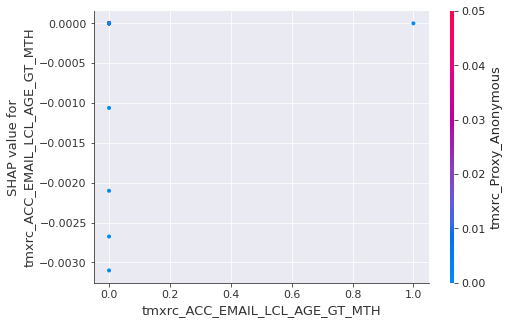

In [ ]:
shap.dependence_plot(6, shap_values[0], X_test, interaction_index="tmxrc_Proxy_Anonymous")

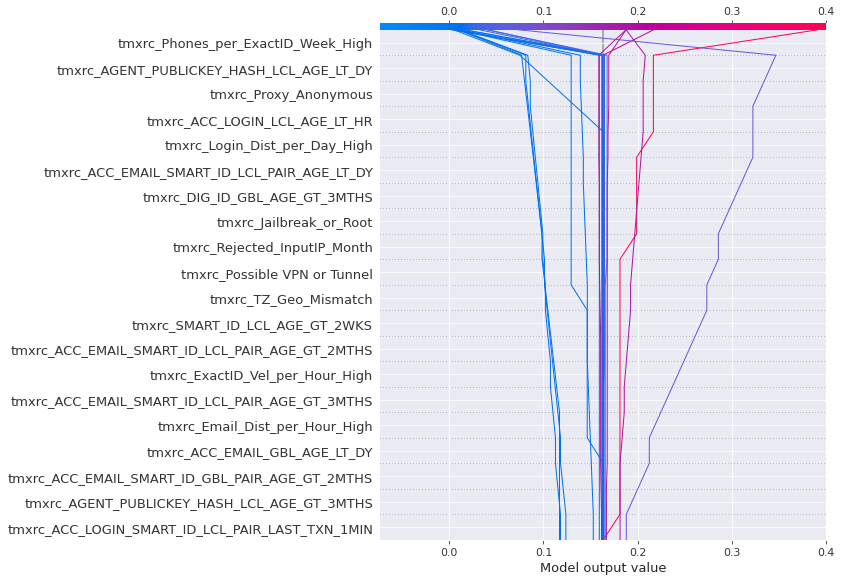

In [ ]:
shap.decision_plot(e.expected_value[0], shap_values[0], modified_rcs)

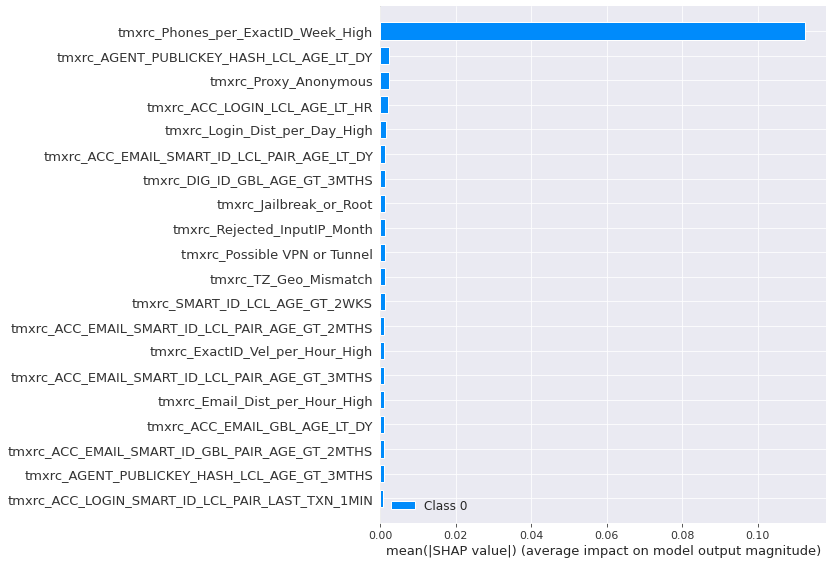

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## 3. Adversarial Autoencoder Neural Network

The Adversarial Autoencoder Neural Network (AAE) architecture, as illustrated in the figure below, extends the concept
of Autoencoder Neural Networks (AE) by imposing an arbitrary prior on the AEs latent space using a GAN training setup. This is achieved by training the AAE jointly in two phases (1) a reconstruction phase as well as (2) an adversarial regularization phase.

In the reconstruction phase, the AAEs encoder network $q_{\theta}(z|x)$ is trained to learn an aggregated posterior distribution $q(z)$ of the journal entries $X$ over the latent code vector $Z$. Thereby, the learned posterior distribution corresponds to a compressed representation of the journal entry characteristics. Similarly to AENs, the decoder
network $p_{\theta}(\hat{x}|z)$ of the AAE utilizes the learned latent code vector representations $Z$ to reconstruct the journal entries $\hat{X}$ as faithfully as possible to minimize the AAEs reconstruction error.

In the regularization phase, an adversarial training setup is applied were the encoder network $q_{\theta}(z|x)$ of the AAE functions as the generator network. In addition, a discriminator network $d_{\theta}(z)$ is attached on top of the learned latent code vector $Z$. Similarly to GANs, the discriminator network of the AAE is trained to distinguish samples of an imposed prior distribution $p(z)$ onto $Z$ from the learned aggregated posterior distribution $q(z)$. In contrast, the encoder network is trained to learn a posterior distribution $p(z) ≈ q(z)$ that fools the discriminator network into thinking that the samples drawn from $q(z)$ originate from the imposed prior distribution $p(z)$.

### 3.1 AAE Implementation - Encoder / Generator Network $q_{\theta}(z|x)$

Now, let's start implementing an AAE by first implementing the encoder-generator network $q_{\theta}(z|x)$ using PyTorch. For the encoder-generator, we aim to implement a network consisting of **five fully-connected layers**. Furthermore, the encoder-generator is specified by the following number of neurons per layer: "618-256-64-16-4-2". Meaning the first layer consists of 618 neurons (specified by the dimensionality of our input data), the second layer of 256 neurons and the subsequent layers of 64, 16, 4 and 2 neurons respectively.

Some elements of the encoder network code below should be given particular attention:

>- `self.encoder_Lx`: defines the linear transformation of the layer applied to the incoming input: $Wx + b$.
>- `nn.init.xavier_uniform`: inits the layer weights using a uniform distribution according to [9].
>- `nn.init.constant`: inits the layer bias with a constant value of 0.0. 
>- `self.encoder_Rx`: defines the non-linear transformation of the layer: $\sigma(\cdot)$.

We use **"Leaky ReLUs"** as introduced by Xu et al. in [7] to avoid "dying" non-linearities and to speed up training convergence. Leaky ReLUs allow a small gradient even when a particular neuron is not active.

In [ ]:
# define encoder class
class Encoder(nn.Module):

    # define class constructor
    def __init__(self, input_size, hidden_size):

        # call super class constructor
        super(Encoder, self).__init__()

        # specify first layer - in 618, out 256
        self.map_L1 = nn.Linear(input_size, hidden_size[0], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 64
        self.map_L2 = nn.Linear(hidden_size[0], hidden_size[1], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 64, out 16
        self.map_L3 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 16, out 4
        self.map_L4 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fifth layer - in 4, out 2
        self.map_L5 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_R5(self.map_L5(x))

        # return result
        return x

In [ ]:
# init training network classes / architectures
encoder_train = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])


if (torch.backends.cudnn.version() != None):
    encoder_train = encoder_train.cuda()

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [ ]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder-generator architecture:\n\n{}\n'.format(now, encoder_train))

### 3.2 AAE Implementation - Decoder Network $p_{\theta}(x|z)$

Let's continue the AAE by implementing the corresponding decoder network. The decoder also consists of five fully-connected layers. Furthermore, the decoder network is intended to **symmetrically mirror** the encoder networks architecture by a layer wise inversion "2-4-16-64-256" of the encoder network layers.

In [ ]:
# define decoder class
class Decoder(nn.Module):

    # define class constructor
    def __init__(self, output_size, hidden_size):

        # call super class constructor
        super(Decoder, self).__init__()

        # specify first layer - in 2, out 4
        self.map_L1 = nn.Linear(hidden_size[0], hidden_size[1], bias=True) # init linearity
        nn.init.xavier_uniform_(self.map_L1.weight) # init weights according to [9]
        nn.init.constant_(self.map_L1.bias, 0.0) # constant initialization of the bias
        self.map_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 4, out 16
        self.map_L2 = nn.Linear(hidden_size[1], hidden_size[2], bias=True)
        nn.init.xavier_uniform_(self.map_L2.weight)
        nn.init.constant_(self.map_L2.bias, 0.0)
        self.map_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 64
        self.map_L3 = nn.Linear(hidden_size[2], hidden_size[3], bias=True)
        nn.init.xavier_uniform_(self.map_L3.weight)
        nn.init.constant_(self.map_L3.bias, 0.0)
        self.map_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify fourth layer - in 64, out 256
        self.map_L4 = nn.Linear(hidden_size[3], hidden_size[4], bias=True)
        nn.init.xavier_uniform_(self.map_L4.weight)
        nn.init.constant_(self.map_L4.bias, 0.0)
        self.map_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fifth layer - in 256, out 618
        self.map_L5 = nn.Linear(hidden_size[4], output_size, bias=True)
        nn.init.xavier_uniform_(self.map_L5.weight)
        nn.init.constant_(self.map_L5.bias, 0.0)
        self.map_S5 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.map_R1(self.map_L1(x))
        x = self.map_R2(self.map_L2(x))
        x = self.map_R3(self.map_L3(x))
        x = self.map_R4(self.map_L4(x))
        x = self.map_S5(self.map_L5(x))

        # return result
        return x

### Prepare data for Pytorch